In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-11-13 16:37:47--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  3.94MB/s    in 0.2s    

2025-11-13 16:37:48 (3.94 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import auc, roc_curve, roc_auc_score, mean_squared_error
from sklearn.feature_extraction import DictVectorizer


In [3]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [6]:
# fill missing values
non_numeric_cols = df.select_dtypes(exclude=['float', 'int']).columns
df[non_numeric_cols] = df[non_numeric_cols].fillna('NA')
df[non_numeric_cols]= df[non_numeric_cols].replace("", 'NA')

numeric_cols = df.select_dtypes(include=['float', 'int']).columns
df[numeric_cols] = df[numeric_cols].fillna(0)
df

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,0.0,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,0.0,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369
...,...,...,...,...,...,...,...,...,...,...,...
9699,140,5.0,164.0,2981.107371,17.3,2013,Europe,Diesel,Front-wheel drive,0.0,15.101802
9700,180,0.0,154.0,2439.525729,15.0,2004,USA,Gasoline,All-wheel drive,0.0,17.962326
9701,220,2.0,138.0,2583.471318,15.1,2008,USA,Diesel,All-wheel drive,-1.0,17.186587
9702,230,4.0,177.0,2905.527390,19.4,2011,USA,Diesel,Front-wheel drive,1.0,15.331551


In [12]:
dv = DictVectorizer(sparse=False)


df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=1)
X_train_val = dv.fit_transform(df_train_val.drop('fuel_efficiency_mpg', axis=1).to_dict(orient='records'))
y_train_val = df_train_val['fuel_efficiency_mpg'].values


dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train_val, y_train_val)
tree = dt.tree_
feature_names = dv.get_feature_names_out()

print("Feature used for split:", feature_names[tree.feature[0]])
print("Threshold used:", tree.threshold[0])


Feature used for split: vehicle_weight
Threshold used: 3024.4688720703125


In [15]:
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=1)
X_train = dv.transform(df_train.drop('fuel_efficiency_mpg', axis=1).to_dict(orient='records'))
y_train = df_train['fuel_efficiency_mpg'].values

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

X_val = dv.transform(df_val.drop('fuel_efficiency_mpg', axis=1).to_dict(orient='records'))
y_val = df_val['fuel_efficiency_mpg'].values
y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred)**0.5
print("Validation RMSE:", rmse)

Validation RMSE: 0.45707126026197337


In [18]:
# find best n estimators for the tree

rmse_list = []
for n in np.arange(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse_list.append(mean_squared_error(y_val, y_pred)**0.5)
    print(f"n_estimators: {n}, Validation RMSE: {rmse_list[-1]}")

n_estimators: 10, Validation RMSE: 0.4570712602619733
n_estimators: 20, Validation RMSE: 0.4517167074216116
n_estimators: 30, Validation RMSE: 0.45003910387142393
n_estimators: 40, Validation RMSE: 0.44770686653672553
n_estimators: 50, Validation RMSE: 0.44605309628720213
n_estimators: 60, Validation RMSE: 0.4450828687186986
n_estimators: 70, Validation RMSE: 0.4446045819521307
n_estimators: 80, Validation RMSE: 0.4448128961209613
n_estimators: 90, Validation RMSE: 0.44438831338808243
n_estimators: 100, Validation RMSE: 0.44416784987069025
n_estimators: 110, Validation RMSE: 0.44315334169530546
n_estimators: 120, Validation RMSE: 0.44346598726695746
n_estimators: 130, Validation RMSE: 0.44313230208561327
n_estimators: 140, Validation RMSE: 0.4429196344485449
n_estimators: 150, Validation RMSE: 0.44249484822150426
n_estimators: 160, Validation RMSE: 0.44221188077878715
n_estimators: 170, Validation RMSE: 0.4424158219057408
n_estimators: 180, Validation RMSE: 0.4419978650677652
n_estimat

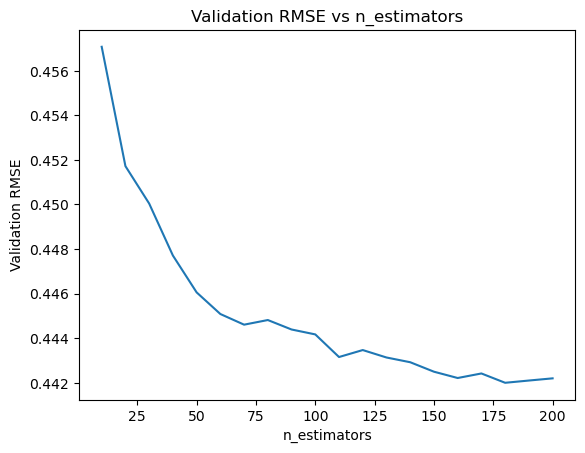

In [19]:
import matplotlib.pyplot as plt
plt.plot(np.arange(10, 201, 10), rmse_list)
plt.xlabel('n_estimators')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE vs n_estimators')
plt.show()

max_depth: 10, n_estimators: 200, Validation RMSE: 0.44177370392969173
max_depth: 15, n_estimators: 200, Validation RMSE: 0.4450240433962002
max_depth: 20, n_estimators: 200, Validation RMSE: 0.4459547840883615
max_depth: 25, n_estimators: 200, Validation RMSE: 0.445408466437377


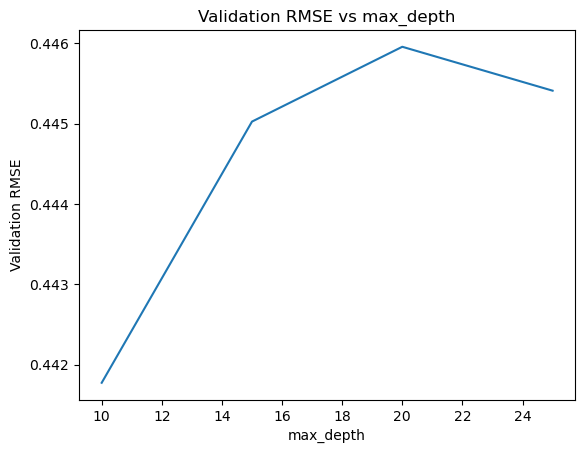

In [20]:
# select best mac depth

rmse_list_depth = []
for depth in [10, 15, 20, 25]:

    rmse_list_n = []
    for n in np.arange(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse_list_n.append(mean_squared_error(y_val, y_pred)**0.5)

    rmse_list_depth.append(np.mean(rmse_list_n))
    print(f"max_depth: {depth}, n_estimators: {n}, Validation RMSE: {rmse_list_depth[-1]}")

plt.plot([10, 15, 20, 25], rmse_list_depth)
plt.xlabel('max_depth')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE vs max_depth')
plt.show()

In [29]:
# train a random forst and find feature importance

rf = RandomForestRegressor(n_estimators=10,max_depth=20,random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
feat_imp 

,feature,importance
13,vehicle_weight,0.959176
6,horsepower,0.016042
0,acceleration,0.011454
3,engine_displacement,0.003282
7,model_year,0.003165
8,num_cylinders,0.002331
9,num_doors,0.001628
12,origin=USA,0.000565
11,origin=Europe,0.000494
10,origin=Asia,0.000485


In [36]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
!pip install xgboost
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names.tolist())
#watchlist = [(dtrain, 'train'), (dval, 'val')]
model = xgb.train(xgb_params, dtrain, num_boost_round=100) #), evals=watchlist)

#rmse score 
y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred)**0.5
print("XGBoost Validation RMSE:", rmse)


XGBoost Validation RMSE: 0.45017755678087246


In [38]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names.tolist())

model = xgb.train(xgb_params, dtrain, num_boost_round=100) #), evals=watchlist)
#rmse score 
y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred)**0.5
print("XGBoost Validation RMSE with eta 0.1:", rmse)


XGBoost Validation RMSE with eta 0.1: 0.42622800553359225
